# Prediction of car prices

## Project work plan 

### 1. Research Objective

Conduct a data analysis to predict the market value of a car based on such features as its technical specifications, configurations, and the prices of similar vehicles.

What has to be considered: 
- Usage of RMSE metric
- Model training time
- Model prediction time

### 2. Research Tasks

   - Load and explore the data (data cleaning, handling missing values, duplicates, and outliers)
   - Perform exploratory data analysis (EDA)
   - Analyze correlations between features
   - Prepare data for model training
   - Select and train models. In this project, we will use techniques such as Linear Regression and Gradient Boosting (LightGBM, CatBoost)
   - Tune the hyperparameters of the models to improve prediction quality
   - Evaluate the models based on the following criteria:
      - Prediction quality: Calculate RMSE on the validation set.
      - Training time: Measure the time required to train each model.
      - Prediction time: Measure the time required to make predictions on the validation set.
      - Compare the results of all models and select the best one based on the combination of criteria (prediction quality, training time, and prediction time).
      - Run best model on the test set 
      
### 3. Data Source:

- Dataset: `autos.csv`, containing data on cars.


## Initial analysis

### Importing libraries


For the preparations lets first import the necessary libraries

In [7]:
!pip install lightgbm -q

In [8]:
!pip install phik -q

In [9]:
pip install catboost==1.2.7 -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import os
import phik
import time
import subprocess
import sys
import re


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,  
                                   StandardScaler)

from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

###  Load the files 

In [13]:
pth1_autos = 'autos.csv'
pth2_autos = '/datasets/autos.csv'

if os.path.exists(pth1_autos):
    df_autos = pd.read_csv(pth1_autos)
elif os.path.exists(pth2_autos):
    df_autos = pd.read_csv(pth2_autos)
else:
    print('Something is wrong with autos.csv')


### Data formatting

Let's convert the columns to lowercase and change the column names to "snake_case".

In [16]:
df_autos.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df_autos.columns]
print(df_autos.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


Change data type for the columns data_crawled, last_seen, date_created to datetime type

In [18]:
df_autos['date_crawled'] = pd.to_datetime(df_autos['date_crawled']).dt.date
df_autos['last_seen'] = pd.to_datetime(df_autos['last_seen']).dt.date
df_autos['date_created'] = pd.to_datetime(df_autos['date_created']).dt.date

##  Data Preparation

In [20]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Missing data analysis

In [22]:
print(df_autos.isnull().sum())

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


**Conclusion:**
- The dataset contains 354,369 observations and 16 features + ID.
- Missing values were found in the columns: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired`.
- It was decided to leave the missing values as they are.

### Duplicates analysis

Checking the duplicates 

In [26]:
print(df_autos.duplicated().sum())

6828


In [27]:
shape_before = df_autos.shape
print(shape_before)
df_autos = df_autos.drop_duplicates()
shape_after = df_autos.shape
print(shape_after)


(354369, 16)
(347541, 16)


Now we check implicit duplicates by choosing columns which have unique values 'price', 'registration_year', 'power', 'kilometer', 'brand', 'model'

In [29]:
duplicate_rows = df_autos.duplicated(subset=['price', 'registration_year', 'power', 'kilometer', 'brand', 'model'])
duplicates = df_autos[duplicate_rows]

num_duplicates = duplicates.shape[0]
print(f"Number of duplicates: {num_duplicates}")


Number of duplicates: 76277



It has been decided to delete 6828 duplicates, but to leave implicit duplicates as deletion might cause shortage of data for model training  

## Exploratory data analysis 

Let’s take a look at the general statistical indicators for the quantitative features in df_autos:

In [33]:
df_autos.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,347541.000000,347541.000000,347541.000000,347541.000000,347541.000000,347541.0,347541.000000
mean,4404.640281,2004.228609,109.970375,128248.293007,5.708003,0.0,50546.043578
std,4510.496798,90.721786,190.658861,37904.653490,3.728433,0.0,25787.687139
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,68.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49424.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71126.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- The price has a minimum value of 0, which needs to be checked for anomalies.
- The registration year has a minimum of 1000 and a maximum of 9999, which are also anomalies.
- A power of zero should be investigated, as well as the maximum power of 20,000.
- The registration month has a minimum of 0, which likely indicates missing data.
- The "number of pictures" column contains no data and can be deleted.

Let's examine the histogram of the target variable and the boxplot diagrams of the features.

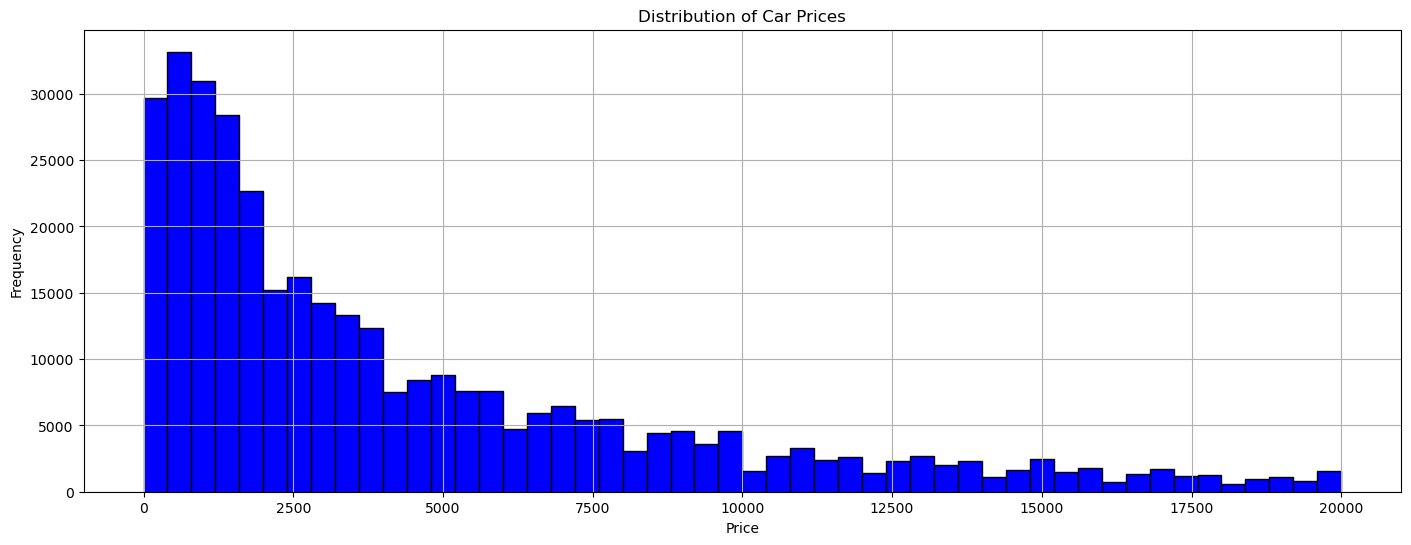

In [36]:
plt.figure(figsize=(17, 6))
plt.hist(df_autos['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

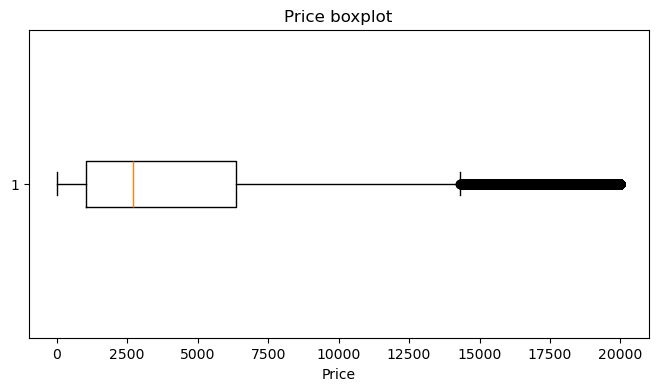

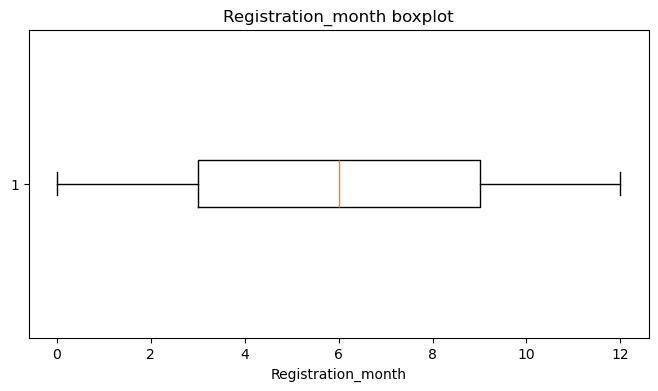

In [37]:
columns_to_plot = ['price', 'registration_month']

for column in columns_to_plot:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df_autos[column], vert=False)
    plt.xlabel(column.capitalize())
    plt.title(f'{column.capitalize()} boxplot')
    plt.show()

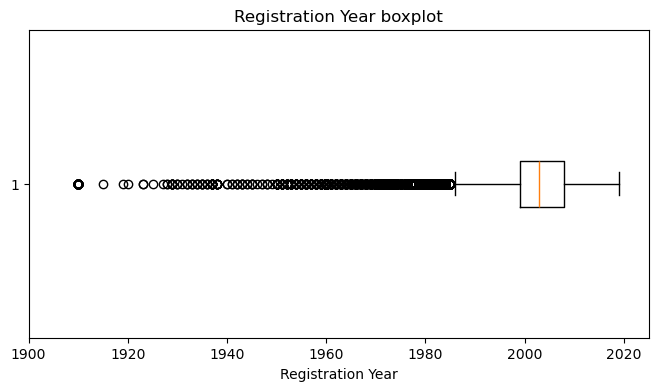

In [38]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_autos['registration_year'], vert=False)
plt.xlabel('Registration Year')
plt.title('Registration Year boxplot')
plt.xlim(1900, 2025) 
plt.show()


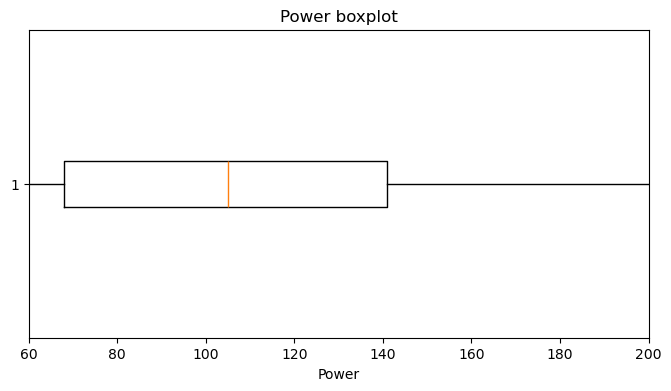

In [39]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_autos['power'], vert=False)
plt.xlabel('Power')
plt.title('Power boxplot')
plt.xlim(60, 200) 
plt.show()

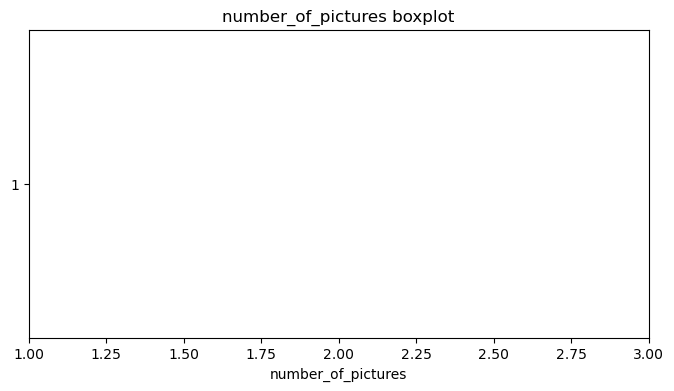

In [40]:
plt.figure(figsize=(8, 4))
plt.boxplot(df_autos['number_of_pictures'], vert=False)
plt.xlabel('number_of_pictures')
plt.title('number_of_pictures boxplot')
plt.xlim(1, 3) 
plt.show()

The column number of pictures does not bring any value for our analysis and can be deleted 

In [42]:
df_autos = df_autos.drop('number_of_pictures', axis=1)

For other features we filter out the outliers and anomalies 

In [44]:
print(df_autos.shape)
df_autos = df_autos[df_autos['price'] > 0]
print(df_autos.shape)

(347541, 15)
(336930, 15)


In [45]:
print(df_autos.shape)
df_autos = df_autos[df_autos['registration_month'] > 0]
print(df_autos.shape)

(336930, 15)
(304397, 15)


The latest data download date from the database is from 2016, meaning any data after that should be considered erroneous.

In [47]:
df_autos['date_crawled'].max()

datetime.date(2016, 4, 7)

In [48]:
print(df_autos.shape)
df_autos = df_autos[(df_autos['registration_year'] > 1990)& (df_autos['registration_year'] <= 2016) ] 
print(df_autos.shape)

(304397, 15)
(285145, 15)


In [49]:
print(df_autos.shape)
df_autos = df_autos[(df_autos['power'] >= 40)& (df_autos['power'] <= 2000)]
print(df_autos.shape)

(285145, 15)
(264663, 15)


Now we check categorical features using pie doagramms

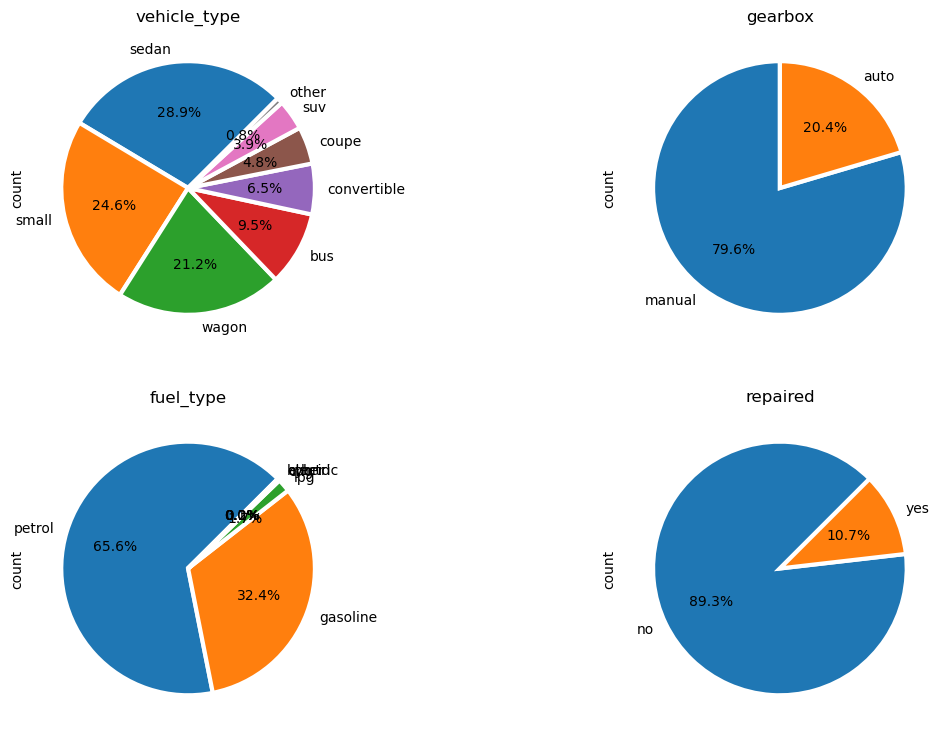

In [51]:
columns = [
    ('vehicle_type', 'vehicle_type', 45),
    ('gearbox', 'gearbox', 90),
    ('fuel_type', 'fuel_type', 45), 
    ('repaired', 'repaired', 45)
]

plt.figure(figsize=(14, 14))

for i, (column, title, angle) in enumerate(columns, 1):
    plt.subplot(3, 2, i)
    data = df_autos[column].value_counts()
    data.plot(kind='pie', autopct='%1.1f%%', startangle=angle, wedgeprops={'linewidth': 3, 'edgecolor': 'white'})
    plt.title(title)

plt.show()

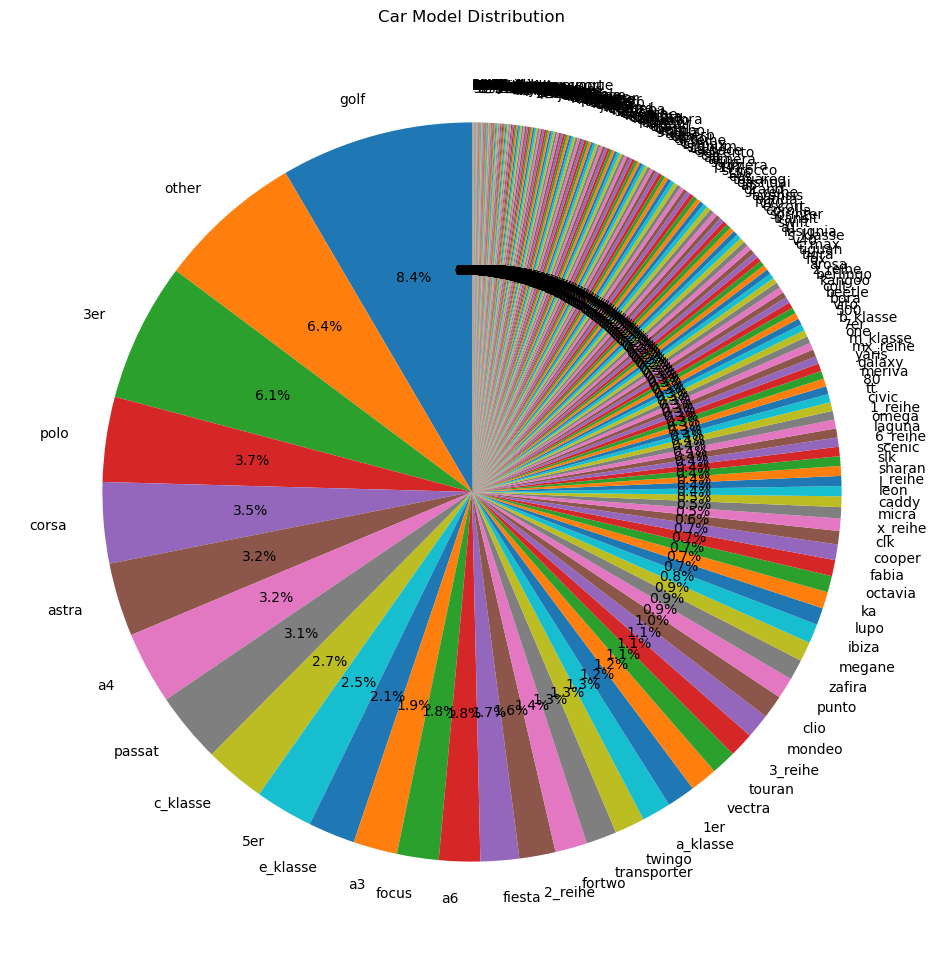

In [52]:
plt.figure(figsize=(12, 12))  
df_autos['model'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title('Car Model Distribution')
plt.ylabel('')  
plt.show()

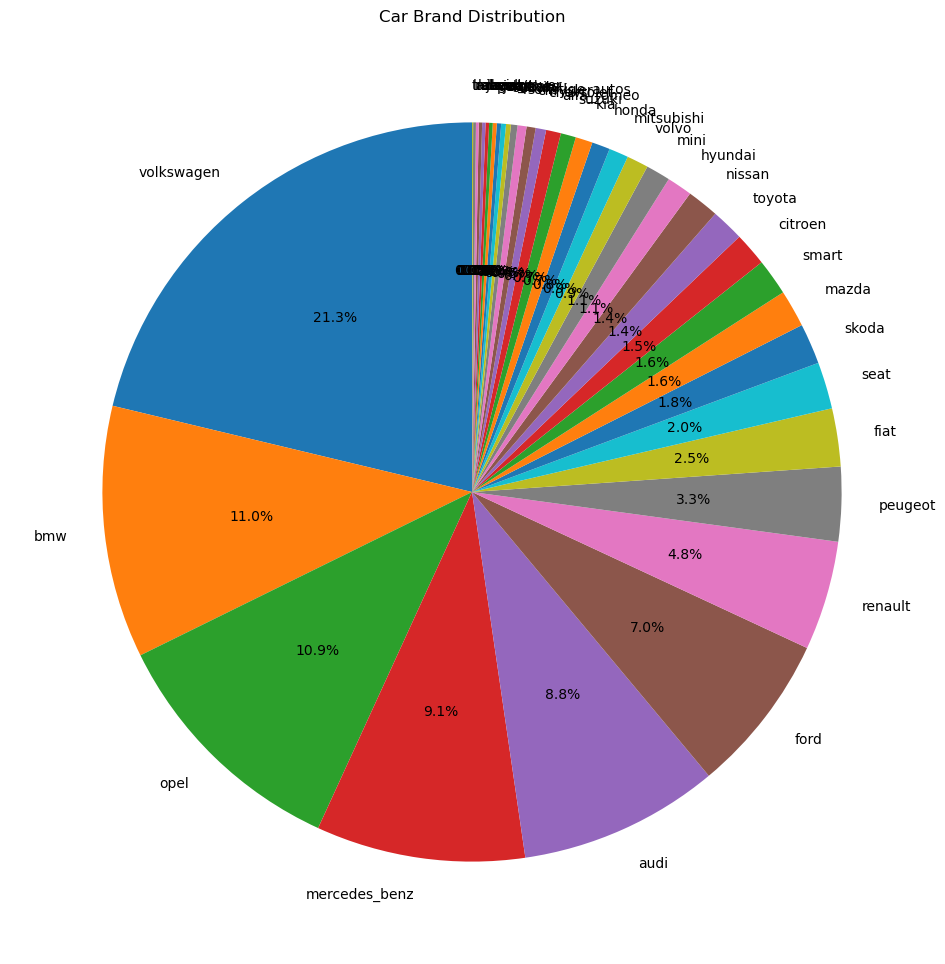

In [53]:
plt.figure(figsize=(12, 12))  
df_autos['brand'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title('Car Brand Distribution')
plt.ylabel('')  
plt.show()

Categorical data looks ok, we leave it as it is

## Correlation analysis

Here we conduct correlation analysis using phik as it is suitable for both numeric and categorical data

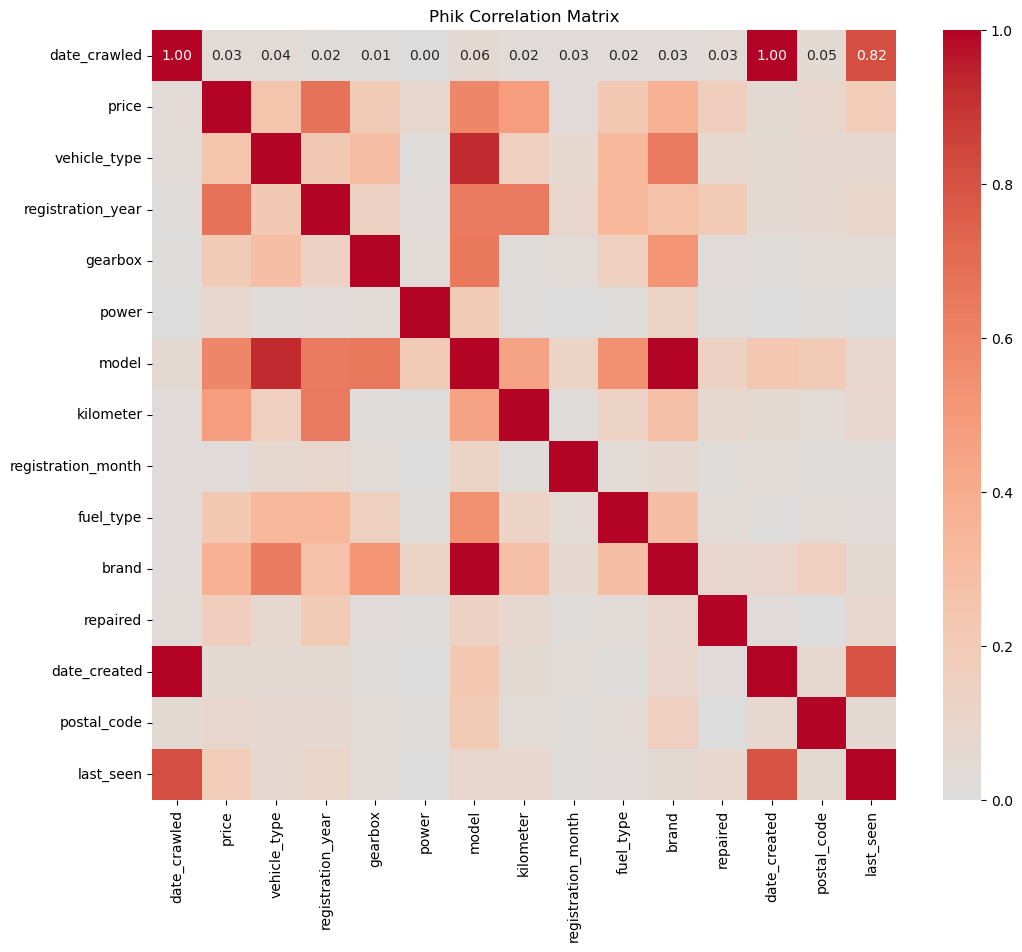

In [57]:
interval_cols = ['kilometer', 'price', 'power', 'postal_code']

bins = {
    'kilometer': 5,
    'price': 5,
    'power': 5,
    'postal_code': 5
}
phik_matrix = df_autos.phik_matrix(interval_cols=interval_cols, bins=bins)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Phik Correlation Matrix")
plt.show()

In [58]:
display(phik_matrix)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
date_crawled,1.000000,0.034323,0.037148,0.019712,0.013569,0.000000,0.056884,0.024297,0.028451,0.023522,0.026389,0.031424,0.999497,0.052034,0.817217
price,0.034323,1.000000,0.254500,0.676011,0.200966,0.084140,0.590189,0.479057,0.026832,0.221733,0.373507,0.169640,0.051608,0.089960,0.185720
vehicle_type,0.037148,0.254500,1.000000,0.213406,0.292817,0.021890,0.922084,0.162894,0.074662,0.329976,0.636875,0.073199,0.055870,0.063118,0.068395
registration_year,0.019712,0.676011,0.213406,1.000000,0.134723,0.030345,0.633837,0.644226,0.087131,0.331067,0.270568,0.196516,0.057478,0.065960,0.102190
gearbox,0.013569,0.200966,0.292817,0.134723,1.000000,0.038771,0.649080,0.019806,0.039055,0.154612,0.525148,0.030052,0.022331,0.039986,0.032773
power,0.000000,0.084140,0.021890,0.030345,0.038771,1.000000,0.203094,0.014784,0.002951,0.018426,0.121776,0.008393,0.000000,0.011423,0.000000
model,0.056884,0.590189,0.922084,0.633837,0.649080,0.203094,1.000000,0.449305,0.124371,0.542903,0.998529,0.140953,0.232752,0.203041,0.091878
kilometer,0.024297,0.479057,0.162894,0.644226,0.019806,0.014784,0.449305,1.000000,0.019934,0.129899,0.279410,0.074924,0.049383,0.039343,0.084137
registration_month,0.028451,0.026832,0.074662,0.087131,0.039055,0.002951,0.124371,0.019934,1.000000,0.042091,0.063962,0.019036,0.042161,0.022248,0.020136
fuel_type,0.023522,0.221733,0.329976,0.331067,0.154612,0.018426,0.542903,0.129899,0.042091,1.000000,0.291011,0.032976,0.009735,0.040309,0.025597


- `date_crawled` and `date_created` have a very strong correlation of 0.999. It doesn't make sense to keep both columns in the dataset for training. The `date_crawled` column (date of data download) can be removed.
- Similarly, the `model` and `brand` columns show a strong correlation of 0.098. Therefore, the `model` column can be removed, as the `brand` column alone should be sufficient.

In [60]:
df_autos = df_autos.drop(['model', 'date_crawled'], axis = 1) 
df_autos.head(2)

,price,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
1,18300,coupe,2011,manual,190,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07
2,9800,suv,2004,auto,163,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05


Analyzing the remaining features, we can identify some that may not be very important for training the model. For example, `postal_code` and `registration_month` could be considered less relevant.

In [62]:
df_autos = df_autos.drop(['registration_month', 'postal_code', 'last_seen'], axis = 1) 
df_autos.head(2)

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired,date_created
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,125000,gasoline,jeep,NaN,2016-03-14


Thus, we have removed 6 irrelevant features: `number_of_pictures`, `model`, `date_crawled`, `postal_code`, `registration_month`, and `last_seen`. Let's check the data for explicit duplicates:

In [64]:
print(df_autos.duplicated().sum())

5640


And delete these dupliactes 

In [66]:
shape_before = df_autos.shape
print(shape_before)
df_autos = df_autos.drop_duplicates()
shape_after = df_autos.shape
print(shape_after)


(264663, 10)
(259023, 10)


## Model training 

At this stage, we will perform the following steps:

1. Store the numerical and categorical features.
2. Create a preprocessing pipeline for feature encoding using `StandardScaler()` for numerical features and `OneHotEncoder()` for categorical features.
3. Define the `evaluate_model()` function to analyze the model, where the pipeline for preprocessing and the model (passed as a parameter) will be executed. In this function, we will train the model and predict the target variable on validation set, including time tracking for training and prediction. Then, we will save the results in a list.
4. Split the dataset into training and test sets. The target feature is `price`.
5. Initialize models with hyperparameters:
   - LightGBM
   - Linear Regression
   - CatBoost  
   and call the `evaluate_model()` method for each model.  
6. Using  RMSE as the evaluation metric and time performance results we will define the best model and do the prediction on test set. 


In [69]:
numerical_features = ['registration_year', 'power', 'kilometer']
categorical_features = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown = 'ignore', drop='first', sparse_output=False), categorical_features)
    ]
)


#create a list to store results 
results = []

#function for model eveluation 
def evaluate_model(model, model_name): 
    pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor), 
        ('model', model)
    ])
# time for training 
    start_train = time.time()
    pipeline.fit(X_train,y_train)
    end_train = time.time()
    training_time = end_train - start_train 
    
# time for prediction
    start_pred = time.time()
    y_pred = pipeline.predict(X_valid)
    end_pred = time.time()
    prediction_time = end_pred- start_pred
# calculate rmse
    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
#save results 
    results.append({
        'Model': model_name, 
        'RMSE': rmse, 
        'Training time, s': training_time, 
        'Prediction time, s': prediction_time
    })


In [70]:
#split to train, valid and test sets
RANDOM_STATE = 42


X = df_autos.drop(['price'], axis=1)
y = df_autos['price']

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5,random_state=RANDOM_STATE)



In [71]:
print(f"Training set size is {X_train.shape[0]} samples with number of columns {X_train.shape[1]}")
print(f"Validation set size is {X_valid.shape[0]} samples with number of columns {X_valid.shape[1]}")
print(f"Test set size is {X_test.shape[0]} samples with number of columns {X_test.shape[1]}")

Training set size is 155413 samples with number of columns 9
Validation set size is 51805 samples with number of columns 9
Test set size is 51805 samples with number of columns 9


In [72]:
# LightGBM with hyperparameters
lgbm = LGBMRegressor(
    n_estimators=200,           
    learning_rate=0.05,         
    max_depth=5,                
    num_leaves=40, 
    min_gain_to_split=0.1,
    random_state=RANDOM_STATE
)
evaluate_model(lgbm, 'LightGBM')

# CatBoost with hyperparameters
catboost = CatBoostRegressor(
    iterations=199,            
    learning_rate=0.05,         
    depth=7,                    
    random_seed=RANDOM_STATE,  
    silent=True
)
evaluate_model(catboost, 'CatBoost')

# Linear Regression with hyperparameters
linear = LinearRegression()
evaluate_model(linear, 'Linear Regression')


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 155413, number of used features: 59
[LightGBM] [Info] Start training from score 5007.714297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

## Choosing best model 

Lets check the results

In [75]:
results_df = pd.DataFrame(results)
display(results_df)

,Model,RMSE,"Training time, s","Prediction time, s"
0,LightGBM,1689.695939,1.435294,0.171844
1,CatBoost,1704.690479,3.679163,0.701585
2,Linear Regression,2488.890103,1.551797,0.060434


- After several iterations adjusting hyperparameters such as the number of iterations, number of leaves, and depth, the best result on the validation set was achieved by the LightGBM model with an RMSE of 1689 and a total runtime of 6 seconds.
- CatBoost takes second place with an RMSE of 1704, but it ranks first in prediction time, completing in 7.9 seconds.
- Linear Regression is quite fast at 2 seconds but performs the worst, with an RMSE of 2488.

Thus, the best model is **LightGBM** with the following hyperparameters:  
- `n_estimators=200`  
- `learning_rate=0.05`  
- `max_depth=5`  
- `num_leaves=40`  
- `min_gain_to_split=0.1`

### Prediction on test set using best model 

The best hyperparameters have been selected, and now we will make predictions on the test set.

In [79]:
lgbm_best = LGBMRegressor(
    n_estimators=200,           
    learning_rate=0.05,         
    max_depth=5,                
    num_leaves=40, 
    min_gain_to_split=0.1,
    random_state=RANDOM_STATE
)

pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgbm_best)
])

pipeline_best.fit(X_train, y_train)


y_test_pred = pipeline_best.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print(f"RMSE on test set : {rmse_test}")

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 155413, number of used features: 59
[LightGBM] [Info] Start training from score 5007.714297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with